In [1]:
import torch_geometric
import pickle
from scene_graph import NodeType
from torch_geometric.loader import DataLoader
from load_matterport3d_dataset import Matterport3dDataset
import torch.nn.functional as F
from extract_labels import create_label_lists
import torch
from model_utils import get_category_index_map
import matplotlib.pyplot as plt
import numpy as np

In [17]:
label_set = "nyuClass"
dataset = Matterport3dDataset(f"./mp_data/{label_set}_matterport3d_w_edge_502030.pkl")
dataloader = DataLoader(dataset, batch_size = len(dataset))
batch = next(iter(dataloader))

In [18]:
labels, pl_labels = create_label_lists(dataset)
building_list, room_list, object_list = labels
building_list_pl, room_list_pl, object_list_pl = pl_labels

label = (
    batch.y[batch.building_mask],
    batch.y[batch.room_mask],
    batch.y[batch.object_mask],
)
y_object = F.one_hot(label[-1], len(object_list)).type(torch.LongTensor)

# Each of these tensors is size [2, # edges of given type]. Name describes two nodes in each edge,
# e.g. room_building means one is a room and other is building
(room_building_edge_index, \
object_room_edge_index, \
room_edge_index,\
object_edge_index,) = (\
    batch.room_building_edge_index, \
    batch.object_room_edge_index, \
    batch.room_edge_index, \
    batch.object_edge_index,)
# Integer tensor of size [# nodes], where each node is 
# given a unique number among the nodes of same type,
# e.g. if nodes are of nodetype [B, B, R, O, R, O, B], 
# then returned tensor is [0, 1, 0, 0, 1, 1, 2]
category_index_map = get_category_index_map(batch)

x_object = batch.x[batch.object_mask]
x_room = batch.x[batch.room_mask]

In [19]:
datasets = [
    dataset.get_training_set(), 
    dataset.get_validation_set(), 
    dataset.get_test_set()
]
splits = ["train", "validation", "test"]
formatted_data = {}
ROUND_TO = 3
num_objs = []

for split_idx, ds in enumerate(datasets):
    dataloader = DataLoader(ds, batch_size = len(ds))
    batch = next(iter(dataloader))
    
    label = (
        batch.y[batch.building_mask],
        batch.y[batch.room_mask],
        batch.y[batch.object_mask],
    )
    y_object = F.one_hot(label[-1], len(object_list)).type(torch.LongTensor)

    # Each of these tensors is size [2, # edges of given type]. Name describes two nodes in each edge,
    # e.g. room_building means one is a room and other is building
    (room_building_edge_index, \
    object_room_edge_index, \
    room_edge_index,\
    object_edge_index,) = (\
        batch.room_building_edge_index, \
        batch.object_room_edge_index, \
        batch.room_edge_index, \
        batch.object_edge_index,)
    # Integer tensor of size [# nodes], where each node is 
    # given a unique number among the nodes of same type,
    # e.g. if nodes are of nodetype [B, B, R, O, R, O, B], 
    # then returned tensor is [0, 1, 0, 0, 1, 1, 2]
    category_index_map = get_category_index_map(batch)

    x_object = batch.x[batch.object_mask]
    x_room = batch.x[batch.room_mask]
    
    descriptions, room_labels, room_index = [], [], []
    
    room_counts = {rm : 0 for rm in room_list}
    obj_counts = {}
    for i in range(len(label[1])):
        mask = category_index_map[object_room_edge_index[1]] == i
        neighbor_dists = y_object[category_index_map[object_room_edge_index[0][mask]]]
        if len(neighbor_dists) >= 100 or room_list[label[1][i]]\
            in ["None", "porch", "balcony", "yard"]:
            continue
        neighbor_features = x_object[category_index_map[object_room_edge_index[0][mask]]][:, :6]
        avg_obj_location = neighbor_features[:, :3].mean(dim=0)
        x_r, y_r, z_r = x_room[i][3:6]
        x_r, y_r, z_r = round(float(x_r), ROUND_TO), \
                        round(float(y_r), ROUND_TO), \
                        round(float(z_r), ROUND_TO)
        description = f"Room Size:\nx {x_r}\ny {y_r}\nz {z_r}\n\nObject Locations:"
        
        for j in range(len(neighbor_dists)):
            x_o, y_o, z_o = neighbor_features[j][:3] - x_room[i][:3]
            x_o, y_o, z_o = round(float(x_o), ROUND_TO), \
                            round(float(y_o), ROUND_TO), \
                            round(float(z_o), ROUND_TO)
            description += f"\n{object_list[torch.nonzero(neighbor_dists[j])]}"
            description += f"\nx {x_o}\ny {y_o}\nz {z_o}"
            
        descriptions.append(description)
        room_labels.append(room_list[label[1][i]])
        room_index.append(label[1][i])
        num_objs.append(len(neighbor_dists))
        
        room_counts[room_list[label[1][i]]] += 1
        
    formatted_data[splits[split_idx]] = (descriptions, room_labels, room_index)
    # print(room_counts)
    # print(obj_counts)
# TODO: Change filepath back to llm_finetuning directory, or move this nb to 
# original repo
with open(f"../vlm_scene_understanding/sm_data/{label_set}_sm_splits.pkl", "wb") as f:
    pickle.dump(formatted_data, f)


(array([597., 626., 342., 176.,  89.,  42.,  11.,  10.,   3.,   1.]),
 array([ 0. ,  7.1, 14.2, 21.3, 28.4, 35.5, 42.6, 49.7, 56.8, 63.9, 71. ]),
 <BarContainer object of 10 artists>)

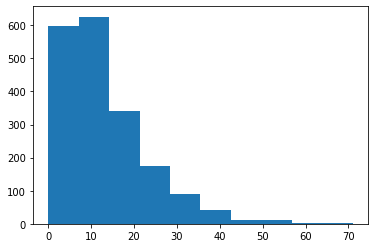

In [6]:
print(room_list)

['None', 'balcony', 'bar', 'bathroom', 'bedroom', 'classroom', 'closet', 'conference auditorium', 'dining room', 'family room', 'game room', 'garage', 'gym', 'hallway', 'kitchen', 'laundry room', 'library', 'living room', 'lobby', 'lounge', 'office', 'porch', 'spa', 'staircase', 'television room', 'utility room', 'yard']
